# Hyperparameter Tuning

## SVM

In [ ]:
param_grid = {
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__C': [0.01, 0.1, 1, 10]
}

In [ ]:
random_search_svm = RandomizedSearchCV(
    estimator=SVM_pipeline,
    param_distributions=param_dist,
    n_iter=5,                     
    scoring='f1',                  
    cv=5,
    verbose=1,
    random_state=randomstate,
    n_jobs=-1
)
random_search_svm.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric_pca',
                                                                               Pipeline(steps=[('impute_encode',
                                                                                                ColumnTransformer(transformers=[('num_disc',
                                                                                                                                 KNNImputer(n_neighbors=3),
                                                                                                                                 ['Age',
                                                                                                                                  'Flight '
                                                                                                                                  'Distance',
                                                                                                                                  'Departure '
                                                                                                                                  'Delay '
                                                                                                                                  'in '
                                                                                                                                  'Minutes',
                                                                                                                                  'Arrival '
                                                                                                                                  'Delay '
                                                                                                                                  'in '
                                                                                                                                  'Minutes',
                                                                                                                                  'Inflight '
                                                                                                                                  'wifi '
                                                                                                                                  'service',
                                                                                                                                  'Departure/Arrival '...
                                        'classifier__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B37CEBA390>,
                                        'classifier__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B37CEB9D90>,
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B36EA8FC20>},
                   random_state=68, scoring='f1', verbose=1)

## K Fold Validation Score 

preview of the 5 best parameter, based on the 'recall' average out of 5 split. <br>
the best model have the average recall of 0.89, with the range of 0.73 to 1.00 between all 5 folds. <br>
the best model have standard deviation of 0.10, showing that the model is preety unstable between all 5 split, as one of the split reaching 1.00 and other split scoring 0.73.

In [ ]:
cross_val_res = pd.DataFrame(random_search_svm.cv_results_)

cross_val_res[['params', 'split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(5)

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,{'classifier__colsample_bytree': 0.87953983453...,0.936805,0.937740,0.937708,0.938068,0.937732,0.937611,0.000424,1
17,{'classifier__colsample_bytree': 0.93570194833...,0.936096,0.937008,0.937328,0.938149,0.937729,0.937262,0.000698,2
20,{'classifier__colsample_bytree': 0.79173559043...,0.936170,0.936494,0.937010,0.938072,0.937211,0.936992,0.000654,3
42,{'classifier__colsample_bytree': 0.71999867904...,0.936307,0.937588,0.935698,0.937193,0.935689,0.936495,0.000775,4
41,{'classifier__colsample_bytree': 0.95328443361...,0.934024,0.935644,0.936740,0.936834,0.938468,0.936342,0.001468,5


## Best Parameter and Model

In [ ]:
random_search_svm.best_params_

{'classifier__colsample_bytree': np.float64(0.8795398345327995),
 'classifier__gamma': np.float64(0.08072773875264116),
 'classifier__learning_rate': np.float64(0.11562497302263064),
 'classifier__max_depth': 7,
 'classifier__n_estimators': 408,
 'classifier__reg_alpha': np.float64(0.15006558593132557),
 'classifier__reg_lambda': np.float64(0.0009093441076322151),
 'classifier__subsample': np.float64(0.8661831836329038)}

Our best hyperparameter for improving the recall score is:
- **Solver - 'saga'**: We only use `'saga'` since it is the only solver that supports all three types of penalties (`l1`, `l2`, and `elasticnet`). 
- **Penalty - 'l1'**: By using L1 regularization, the model tends to push less important feature coefficients to zero (feature selection effect).
- **Max Iterations - 100**: By only using 100 iteration, the model already converge. Increasing this didn’t provide significant improvement in recall.
- **Class Weight - 'balanced'**: Using the `balanced` option helping the model pay more attention to the minority class and increase recall.
- **C Value - 0.0001**: A smaller `C` means stronger regularization. This forces the model to be simpler and reduces overfitting.

Saving our best model in variable

In [ ]:
best_model_svm = random_search_svm.best_estimator_

## Model Evaluation

### SVM

#### Prediction

In [ ]:
predict_train = best_model_svm.predict(x_train) #type:ignore
predict_test = best_model_svm.predict(x_test) #type:ignore
predict_train

#### Confusion Matrix

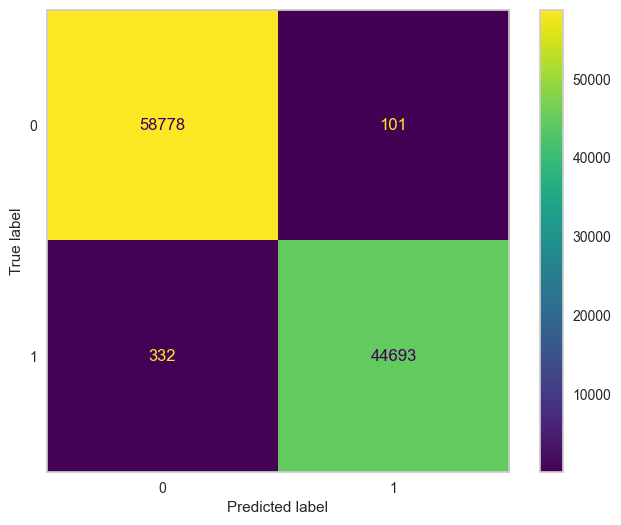

In [ ]:
cm_train = confusion_matrix(y_train, predict_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
fig, ax = plt.subplots(figsize=(8,6)) 
disp.plot(ax=ax, cmap='viridis') 
plt.grid(False) 
plt.show()

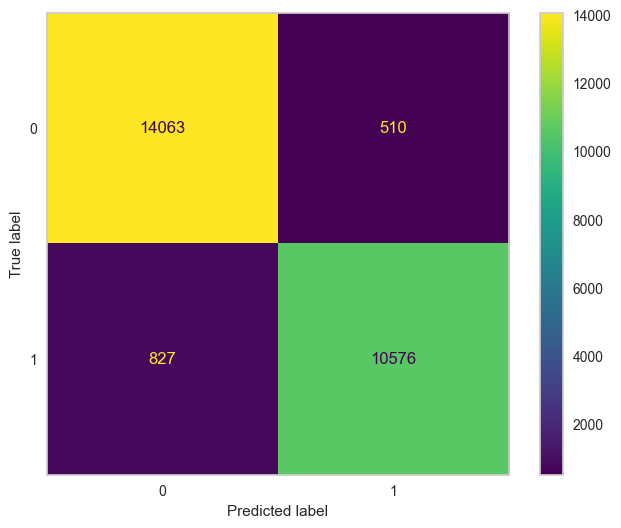

In [ ]:
cm_test = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
fig, ax = plt.subplots(figsize=(8,6)) 
disp.plot(ax=ax, cmap='viridis') 
plt.grid(False) 
plt.show()

From the matrix, the model predicted more false negative (as user that going to buy, considered as not going to buy)

#### Evaluation Metrics

In [ ]:
print('Train')
print(classification_report(y_train, predict_train))
print('')

print('Test')
print(classification_report(y_test, predict_test))

Train
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     58879
           1       1.00      0.99      1.00     45025

    accuracy                           1.00    103904
   macro avg       1.00      1.00      1.00    103904
weighted avg       1.00      1.00      1.00    103904


Test
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     14573
           1       0.95      0.93      0.94     11403

    accuracy                           0.95     25976
   macro avg       0.95      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976



as our positive class is 1 (in actually buying from the website), we have better recall than previous model with same algorithm, scoring 0.02 and 0.01 on train and test respectively

#### Adding Result to Dictionary

In [ ]:
model_report = mla.performance_report(model_report, y_train, predict_train, y_test, predict_test, "SVM Hyperparameter", target_parameter='f1_score')
pd.DataFrame(model_report)

,KNN Classifier,SVM,Decision Tree,Random Forest,XGBoost,XGBoost Hyperparameter
train - f1_score,0.936363,0.942657,1.000000,1.000000,0.960268,0.995179
test - f1_score,0.911871,0.939160,0.889181,0.927869,0.934298,0.940549
